In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
!pip install matplotlib==3.2.0
!pip install geopandas

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from pyproj import Proj, transform
import urllib

import os
import requests
import zipfile

from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn import cluster
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import numpy as np

###For radar plot
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

import warnings
# Settings the warnings to be ignored
warnings.filterwarnings('ignore')

#zipcode for cluster in zipcode level
# or use this
urllib.request.urlretrieve ("https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip",
                            "ZIPS.zip")
with zipfile.ZipFile('ZIPS.zip', 'r') as zip_ref:
    zip_ref.extractall('ZIPS/')

zips = gpd.read_file("ZIPS/ZIP_CODE_040114.shp")
zips = zips[['ZIPCODE', 'POPULATION', 'geometry']]
# Reproject shapefile
zips = zips.to_crs(epsg = 2263)

zips['ZIPCODE'] = zips['ZIPCODE'].astype(int)
zips.head()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 14.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for matplotlib: filename=matplotlib-3.2.0-cp310-cp310-linux_x86_64.whl size=11953714 sha256=b2ed2560ab644d9c67902d8d96f845cfd2cacaead556eab5e1c398ccffa294fb
  Stored in directory: /root/.cache/pip/wheels/58/0a/5e/8397500cf9bccc1e8dacd88d51b4fa9f2aa7e45557d97d5490
Successfully built matplotlib
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mizani 0.8.1 requires matplotlib>=3.5.0, but you have matplotlib 3.2.0 which is incompatible.
plotnine 0.10.1 requires matplotlib>=3.5.0, but you have matplotlib 3.2.0 which is incompatible.


,ZIPCODE,POPULATION,geometry
0,11436,18681.0,"POLYGON ((1038098.252 188138.380, 1038141.936 ..."
1,11213,62426.0,"POLYGON ((1001613.713 186926.440, 1002314.243 ..."
2,11212,83866.0,"POLYGON ((1011174.276 183696.338, 1011373.584 ..."
3,11225,56527.0,"POLYGON ((995908.365 183617.613, 996522.848 18..."
4,11218,72280.0,"POLYGON ((991997.113 176307.496, 992042.798 17..."


## Cluster in census block

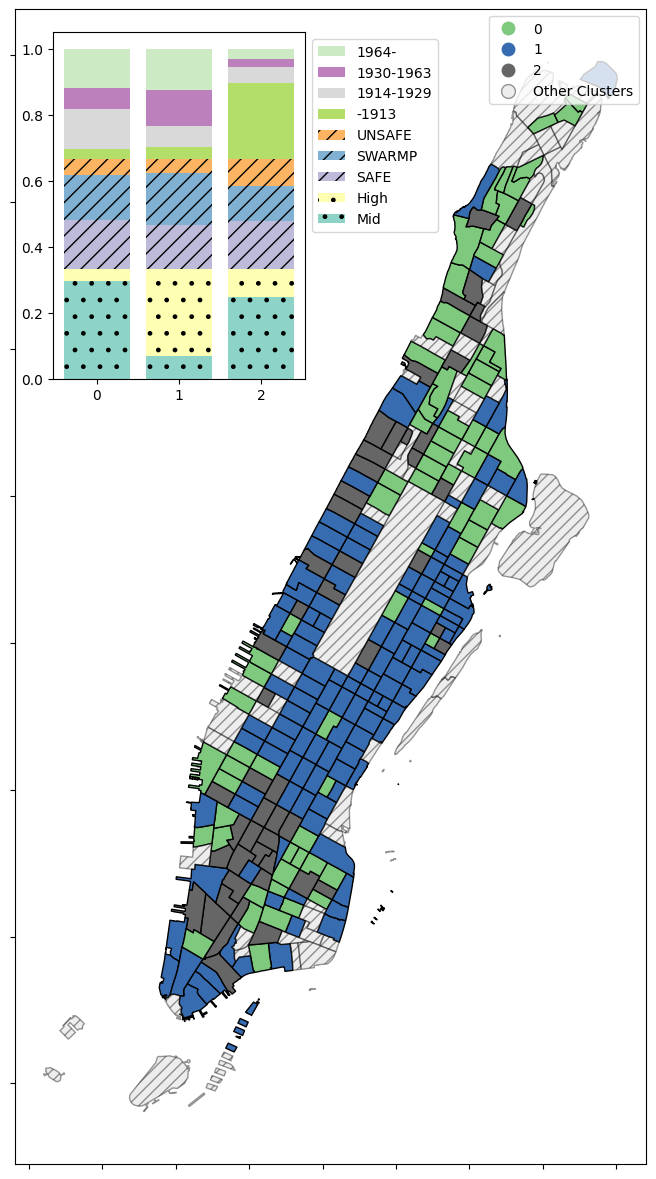

In [ ]:
#### count rodent in each census tract
import urllib.request as urllib
import zipfile

#https://www.nyc.gov/site/planning/data-maps/open-data/census-download-metadata.page

urllib.urlretrieve ("https://s-media.nyc.gov/agencies/dcp/assets/files/zip/data-tools/bytes/nyct2020_23a.zip",
                            "ZIPS.zip")
with zipfile.ZipFile('ZIPS.zip', 'r') as zip_ref:
    zip_ref.extractall('ZIPS/')

nyct2020 = gpd.read_file("ZIPS/nyct2020_23a/nyct2020.shp")
nyct2020 = nyct2020[['GEOID','BoroCode','geometry']]
nyct2020 = nyct2020.to_crs(epsg=2263)
nyct2020_MA = nyct2020[nyct2020.BoroCode=='1']

nyct2020['GEOID'] = nyct2020['GEOID'].astype(int)
nyct2020_MA['GEOID'] = nyct2020_MA['GEOID'].astype(int)


path = '/content/drive/MyDrive/2023 Spring/Other/2022_Overview Of NYC FISP reports/Clustering/archive/test_hub_0401/testCluster_buildingFeatures_allCT_0401.csv'
Feature1 = pd.read_csv(path,index_col='GEOID')

#exclude facadetype
FacadeType = ['Brick masonry', 'Cast iron', 'Concrete', 'Glass', 'Metal and glass', 'Stone limestone','BIN']
selected_col = list(set(Feature1.columns) - set(FacadeType))
FeatureNorm = Feature1[selected_col]

GEOID_MA = nyct2020[nyct2020.BoroCode == '1'].GEOID.tolist()
Feature_MA = FeatureNorm[FeatureNorm.index.isin(GEOID_MA)]

##clustering with KMeans
cluster_num = 3
rr = KMeans(n_clusters = cluster_num, random_state = 0).fit(Feature_MA)
rr.labels_ = rr.predict(Feature_MA) #get labels
clust={Feature_MA.index[i]:rr.labels_[i] for i in range(len(rr.labels_))}
res=pd.DataFrame({'GEOID':Feature_MA.index, 'label':rr.labels_})
# res.to_csv('Gaussian_YearQuantile_4Clust.csv',index=False)

clusterChar = Feature_MA.reset_index().merge(res,left_on='GEOID',right_on='GEOID').\
                    groupby(['label']).sum().reset_index()

#normalize by total cluster activity
clusterChar = clusterChar[[col for col in clusterChar.columns if col not in ['label','GEOID']]]
clusterChar = clusterChar.div(clusterChar.sum(axis=1), axis=0)
clusterChar['label'] = [i for i in range(cluster_num)]

res['label'] = res['label'].astype(str)

fig,ax = plt.subplots(nrows=1, ncols=1,figsize=(15,15))
plt.rcParams["figure.autolayout"] = True
nyct2020_MA.merge(res,left_on='GEOID',right_on='GEOID',how='left').plot(column='label',  cmap='Accent',
                                    legend=True,ax=ax,edgecolor='black', missing_kwds={
                                                            "color": "lightgrey", ## what to do with missing values
                                                            "edgecolor": "black",
                                                            "linewidth": 1,
                                                            "alpha": 0.4,
                                                            "hatch": "///",
                                                            "label": "Other Clusters",
                                                            },)

ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)

ins = ax.inset_axes([0.06,0.68,0.4,0.3])
NUM_COLORS = len(clusterChar.columns)
#camp reference: https://matplotlib.org/stable/gallery/color/colormap_reference.html
cm = plt.cm.get_cmap('Set3', NUM_COLORS)

ins.set_prop_cycle(color = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
bot = np.zeros(cluster_num)

col_order = ['Mid', 'High', 'SAFE', 'SWARMP', 'UNSAFE', '-1913', '1914-1929', '1930-1963', '1964-']

for col in col_order:
    values = clusterChar[col].values
    if col in ['SWARMP','SAFE','UNSAFE']:  #filing status uses hatching pattern,
        ins.bar([i for i in range(cluster_num)], values, bottom = bot, label=col, hatch='//')
    elif col in ['Mid', 'High']: #building height uses dot pattern:
        ins.bar([i for i in range(cluster_num)], values, bottom = bot, label=col, hatch='.')
    else:  #year info uses color block,
        ins.bar([i for i in range(cluster_num)], values, bottom = bot, label=col)
    bot = bot + values

ins.set_xticks([i for i in range(cluster_num)])
handles, labels = ins.get_legend_handles_labels()
order = [i for i in range(len(col_order)-1,0-1,-1)]
ins.legend(bbox_to_anchor=(1.0, 1.0), handles=[handles[idx] for idx in order], labels=[labels[idx] for idx in order])

plt.show()

## Defect Visualize (Census block)

In [ ]:
##modify

nyct2020_MA_label = nyct2020_MA.merge(res,left_on='GEOID',right_on='GEOID')
nyct2020_MA_label = nyct2020_MA_label.rename(columns={'label':'label_first'})

# #add num
path = '/content/drive/MyDrive/2023 Spring/Other/2022_Overview Of NYC FISP reports/Clustering/archive/test_hub_0401/bin_censusBlock.csv'
bin_ct = pd.read_csv(path).iloc[:,1:]
bin_ct = bin_ct.groupby('GEOID').count()[['BIN']]
nyct2020_MA_label = nyct2020_MA_label.merge(bin_ct, right_on='GEOID',left_on='GEOID')
nyct2020_MA_label['coords'] = nyct2020_MA_label['geometry'].apply(lambda x: x.representative_point().coords[:])
nyct2020_MA_label['coords'] = [coords[0] for coords in nyct2020_MA_label['coords']]


path = '/content/drive/MyDrive/2022_Facade Report Analysis/2022_Overview Of NYC FISP reports/Clustering/archive/test_hub_0401/testCluster_buildingDefects_allCT_0404.csv'
# path = '/content/drive/MyDrive/2023 Spring/Other/2022_Overview Of NYC FISP reports/Clustering/archive/test_hub_0401/testCluster_buildingDefects_allCT_0404.csv'
clustDefe = pd.read_csv(path)
clustDefe = clustDefe.set_index('GEOID')
clustDefe_MA = clustDefe[clustDefe.index.isin(GEOID_MA)]

#run the cluster in zipcode first (run the section above first)
cluster_result = res.copy()

#multiple plot
ncols = len(cluster_result.label.unique())
fig,ax = plt.subplots(nrows=1, ncols=ncols,figsize=(25,10))
plt.rcParams["figure.autolayout"] = True

ax_idx = 0
for i in cluster_result.label.unique():
    geolist = cluster_result[cluster_result.label==i].GEOID.tolist()
    clustDefe1 = clustDefe_MA[clustDefe_MA.index.isin(geolist)]

    # score for evaluation
    range_n_clusters = [2, 3, 4, 5, 6, 7]
    #initialize
    opt_clust = -1
    opt_score = -99
    for n_clusters in range_n_clusters: #try different numbers of clusters
        if len(clustDefe1) > n_clusters:
            # rr = GaussianMixture(n_components = n_clusters, random_state = 0).fit(clustDefe1)
            rr = KMeans(n_clusters = n_clusters, random_state = 0).fit(clustDefe1)
            rr.labels_ = rr.predict(clustDefe1)
            #report average Silhouette score
            silhouette_avg = silhouette_score(clustDefe1, rr.labels_)
            # print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))
            if silhouette_avg > opt_score:
                opt_score = silhouette_avg
                opt_clust = n_clusters
    print("For Cluster {},".format(i)+" the optimal cluster number is :{}".format(opt_clust))
    cluster_num = opt_clust

    rr = KMeans(n_clusters = cluster_num, random_state = 0).fit(clustDefe1)
    rr.labels_ = rr.predict(clustDefe1) #get labels
    clust={clustDefe1.index[i]:rr.labels_[i] for i in range(len(rr.labels_))}
    res1=pd.DataFrame({'GEOID':clustDefe1.index, 'label':rr.labels_})
    # res.to_csv('Gaussian_YearQuantile_4Clust.csv',index=False)

    clusterChar = clustDefe1.reset_index().merge(res1,left_on='GEOID',right_on='GEOID').\
                        groupby(['label']).sum().reset_index()

    #normalize by total cluster activity
    clusterChar = clusterChar[[col for col in clusterChar.columns if col not in ['label','GEOID']]]
    clusterChar = clusterChar.div(clusterChar.sum(axis=1), axis=0)
    clusterChar['label'] = [i for i in range(cluster_num)]
    res1['label'] = res1['label'].astype(str)

    nyct2020_MA.merge(res1,on='GEOID',how='left').plot(column='label', #cmap='cool',
                                            legend=True,ax=ax[ax_idx],edgecolor='black',
                                            legend_kwds={'loc':'lower right'}, missing_kwds={
                                                            "color": "lightgrey", ## what to do with missing values
                                                            "edgecolor": "black",
                                                            "linewidth": 2,
                                                            "alpha": 0.5,
                                                            "hatch": "///",
                                                            "label": "Other Clusters",
                                                            },)
    ax[ax_idx].xaxis.set_tick_params(labelbottom=False)
    ax[ax_idx].yaxis.set_tick_params(labelleft=False)


    ###########plot proportion
    ins = ax[ax_idx].inset_axes([0.07,0.68,0.4,0.3])
    NUM_COLORS = len(clusterChar.columns)
    cm = plt.cm.get_cmap('tab20b', NUM_COLORS)

    ins.set_prop_cycle(color = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
    bot = np.zeros(cluster_num)

    for col in clusterChar.columns:
        if col != 'label':
            values = clusterChar[col].values
            if col in ['displacement','deflection','slippage', 'bowing/bulging']:  #filing status uses hatching pattern,
                ins.bar([i for i in range(cluster_num)], values, bottom = bot, label=col, hatch='..')
            elif col in ['repair failure', 'loose','fastener failure','failure','coating failure/peeling/flaking','separation']: #building height uses dot pattern:
                ins.bar([i for i in range(cluster_num)], values, bottom = bot, label=col, hatch='xx')
            elif col in ['crack', 'erosion/pitting','abrasion','chipping','scaling','spall','delamination','cavity']: #building height uses dot pattern:
                ins.bar([i for i in range(cluster_num)], values, bottom = bot, label=col, hatch='///')
            elif col in ['hollow','honeycomb']: #building height uses dot pattern:
                ins.bar([i for i in range(cluster_num)], values, bottom = bot, label=col, hatch='++')
            else:  #year info uses color block,
                ins.bar([i for i in range(cluster_num)], values, bottom = bot, label=col)
            bot = bot + values

    ins.set_xticks([i for i in range(cluster_num)])
    handles, labels = ins.get_legend_handles_labels()
    order = [i for i in range(len(clusterChar.columns)-2,0-1,-1)]
    # ins.legend(bbox_to_anchor=(1.0, 1.5, 0.5, 0.5), handles=[handles[idx] for idx in order], labels=[labels[idx] for idx in order])


#     #####Add extra information: cluster number
#     import math
#     LabelList = zips_MA.merge(res1,on='zipcode',how='left').label.astype('float').tolist()
#     for idx, row in zips_MA.iterrows():
#         if not math.isnan(LabelList[idx]):
#             ax[ax_idx].annotate(text=row['BIN'], xy=row['coords'], horizontalalignment='center', color='black')
#     ax[ax_idx].set_title('Cluster {}'.format(i))
    ax_idx +=1

ins.legend(bbox_to_anchor=(3.3, -0.6, 0.5, 0.5), handles=[handles[idx] for idx in order], labels=[labels[idx] for idx in order]).figure
plt.show()

NameError: ignored

In [ ]:
nyct2020_MA_label = nyct2020_MA.merge(res,left_on='GEOID',right_on='GEOID')
nyct2020_MA_label = nyct2020_MA_label.rename(columns={'label':'label_first'})
nyct2020_MA

NameError: ignored

In [ ]:
##modify

nyct2020_MA_label = nyct2020_MA.merge(res,left_on='GEOID',right_on='GEOID')
nyct2020_MA_label = nyct2020_MA_label.rename(columns={'label':'label_first'})

# #add num
path = '/content/drive/MyDrive/2023 Spring/Other/2022_Overview Of NYC FISP reports/Clustering/archive/test_hub_0401/bin_censusBlock.csv'
bin_ct = pd.read_csv(path).iloc[:,1:]
bin_ct = bin_ct.groupby('GEOID').count()[['BIN']]
nyct2020_MA_label = nyct2020_MA_label.merge(bin_ct, right_on='GEOID',left_on='GEOID')
nyct2020_MA_label['coords'] = nyct2020_MA_label['geometry'].apply(lambda x: x.representative_point().coords[:])
nyct2020_MA_label['coords'] = [coords[0] for coords in nyct2020_MA_label['coords']]


# path = '/content/drive/MyDrive/2022_Facade Report Analysis/2022_Overview Of NYC FISP reports/Clustering/archive/cluster_defe_MA_0307.csv'
path = '/content/drive/MyDrive/2023 Spring/Other/2022_Overview Of NYC FISP reports/Clustering/archive/test_hub_0401/testCluster_buildingDefects_allCT_0404.csv'
clustDefe = pd.read_csv(path)
clustDefe = clustDefe.set_index('GEOID')
clustDefe_MA = clustDefe[clustDefe.index.isin(GEOID_MA)]

#run the cluster in zipcode first (run the section above first)
cluster_result = res.copy()

#multiple plot
ncols = len(cluster_result.label.unique())
rad, ax_rad = plt.subplots(nrows=1, ncols=ncols,subplot_kw=dict(projection='radar'),figsize=(20,10)) #subplot_kw=dict(projection='radar')
# print('in')
plt.rcParams["figure.autolayout"] = True


ax_idx = 0
for i in cluster_result.label.unique():
    geolist = cluster_result[cluster_result.label==i].GEOID.tolist()
    clustDefe1 = clustDefe_MA[clustDefe_MA.index.isin(geolist)]

    # score for evaluation
    range_n_clusters = [2, 3, 4, 5, 6, 7]
    #initialize
    opt_clust = -1
    opt_score = -99
    for n_clusters in range_n_clusters: #try different numbers of clusters
        if len(clustDefe1) > n_clusters:
            # rr = GaussianMixture(n_components = n_clusters, random_state = 0).fit(clustDefe1)
            rr = KMeans(n_clusters = n_clusters, random_state = 0).fit(clustDefe1)
            rr.labels_ = rr.predict(clustDefe1)
            #report average Silhouette score
            silhouette_avg = silhouette_score(clustDefe1, rr.labels_)
            # print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))
            if silhouette_avg > opt_score:
                opt_score = silhouette_avg
                opt_clust = n_clusters
    print("For Cluster {},".format(i)+" the optimal cluster number is :{}".format(opt_clust))
    cluster_num = opt_clust

    ########generate clustering algorithm in the defect cluster
    rr = KMeans(n_clusters = cluster_num, random_state = 0).fit(clustDefe1)
    rr.labels_ = rr.predict(clustDefe1) #get labels
    clust={clustDefe1.index[i]:rr.labels_[i] for i in range(len(rr.labels_))}
    res1=pd.DataFrame({'GEOID':clustDefe1.index, 'label':rr.labels_})

    clusterChar = clustDefe1.reset_index().merge(res1,left_on='GEOID',right_on='GEOID').\
                        groupby(['label']).sum().reset_index()

    #normalize by total cluster activity
    clusterChar = clusterChar[[col for col in clusterChar.columns if col not in ['label','GEOID']]]
    clusterChar = clusterChar.div(clusterChar.sum(axis=1), axis=0)
    clusterChar['label'] = [i for i in range(cluster_num)]
    res1['label'] = res1['label'].astype(str)

    nyct2020_MA.merge(res1,on='GEOID',how='left').plot(column='label', #cmap='cool',
                                            legend=True,ax=ax[ax_idx],edgecolor='black',
                                            legend_kwds={'loc':'lower right'}, missing_kwds={
                                                            "color": "lightgrey", ## what to do with missing values
                                                            "edgecolor": "black",
                                                            "linewidth": 2,
                                                            "alpha": 0.5,
                                                            "hatch": "///",
                                                            "label": "Other Clusters",
                                                            },)
    ax[ax_idx].xaxis.set_tick_params(labelbottom=False)
    ax[ax_idx].yaxis.set_tick_params(labelleft=False)


    # ###########plot proportion
    # ins = ax[ax_idx].inset_axes([0.07,0.68,0.4,0.3])
    # NUM_COLORS = len(clusterChar.columns)
    # cm = plt.cm.get_cmap('tab20b', NUM_COLORS)

    # ins.set_prop_cycle(color = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
    # bot = np.zeros(cluster_num)

    # for col in clusterChar.columns:
    #     if col != 'label':
    #         values = clusterChar[col].values
    #         if col in ['displacement','deflection','slippage', 'bowing/bulging']:  #filing status uses hatching pattern,
    #             ins.bar([i for i in range(cluster_num)], values, bottom = bot, label=col, hatch='..')
    #         elif col in ['repair failure', 'loose','fastener failure','failure','coating failure/peeling/flaking','separation']: #building height uses dot pattern:
    #             ins.bar([i for i in range(cluster_num)], values, bottom = bot, label=col, hatch='xx')
    #         elif col in ['crack', 'erosion/pitting','abrasion','chipping','scaling','spall','delamination','cavity']: #building height uses dot pattern:
    #             ins.bar([i for i in range(cluster_num)], values, bottom = bot, label=col, hatch='///')
    #         elif col in ['hollow','honeycomb']: #building height uses dot pattern:
    #             ins.bar([i for i in range(cluster_num)], values, bottom = bot, label=col, hatch='++')
    #         else:  #year info uses color block,
    #             ins.bar([i for i in range(cluster_num)], values, bottom = bot, label=col)
    #         bot = bot + values

    # ins.set_xticks([i for i in range(cluster_num)])
    # handles, labels = ins.get_legend_handles_labels()
    # order = [i for i in range(len(clusterChar.columns)-2,0-1,-1)]
    # # ins.legend(bbox_to_anchor=(1.0, 1.5, 0.5, 0.5), handles=[handles[idx] for idx in order], labels=[labels[idx] for idx in order])


    #####Add extra information: cluster number
    # import math
    # LabelList = zips_MA.merge(res1,on='zipcode',how='left').label.astype('float').tolist()
    # for idx, row in zips_MA.iterrows():
    #     if not math.isnan(LabelList[idx]):
    #         ax[ax_idx].annotate(text=row['BIN'], xy=row['coords'], horizontalalignment='center', color='black')
    # ax[ax_idx].set_title('Cluster {}'.format(i))


    ######## radar
    clusterChar = clusterChar.loc[:, clusterChar.columns!='label']
    ##filter out data not display in proportion
    filterCol = []
    filterVal = []
    for col, val in zip(clusterChar.columns.tolist(), np.array(clusterChar.values.tolist()).T):
        if not val.any(0):
            pass
        else:
            filterCol.append(col)
            filterVal.append(val.tolist())
    filterVal = np.array(filterVal).T.tolist()

    N = len(filterCol)
    theta = radar_factory(N, frame='polygon')
    data = [filterCol, ('Cluster',filterVal)]

    spoke_labels = data.pop(0)
    # print(spoke_labels, len(spoke_labels),N, len(filterVal[0]))
    # rad, ax_rad[ax_idx] = plt.subplots(subplot_kw=dict(projection='radar'))
    colors = ['b', 'r', 'g', 'm', 'y']

    for (title, case_data) in data:
        ax_rad[ax_idx].set_rgrids([0.2, 0.4, 0.6, 0.8])
        for d, color in zip(case_data, colors):
            ax_rad[ax_idx].plot(theta, d, color=color)
            ax_rad[ax_idx].fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')

        # ax_rad[ax_idx].set_varlabels(spoke_labels)
        ax_rad[ax_idx].set_thetagrids(np.degrees(theta), spoke_labels)

    # add legend relative to top-left plot
    labels = ['Cluster '+str(i) for i in range(len(clusterChar))]
    legend = ax_rad[ax_idx].legend(labels, loc=(0.9, .95),
                                labelspacing=0.1, fontsize='small')

    ax_idx +=1


# ins.legend(bbox_to_anchor=(3.3, -0.6, 0.5, 0.5), handles=[handles[idx] for idx in order], labels=[labels[idx] for idx in order]).figure
plt.show()
# fig.savefig('temp.png', dpi=fig.dpi)

ValueError: ignored

<Figure size 2000x1000 with 0 Axes>

## Cluster in zipcode

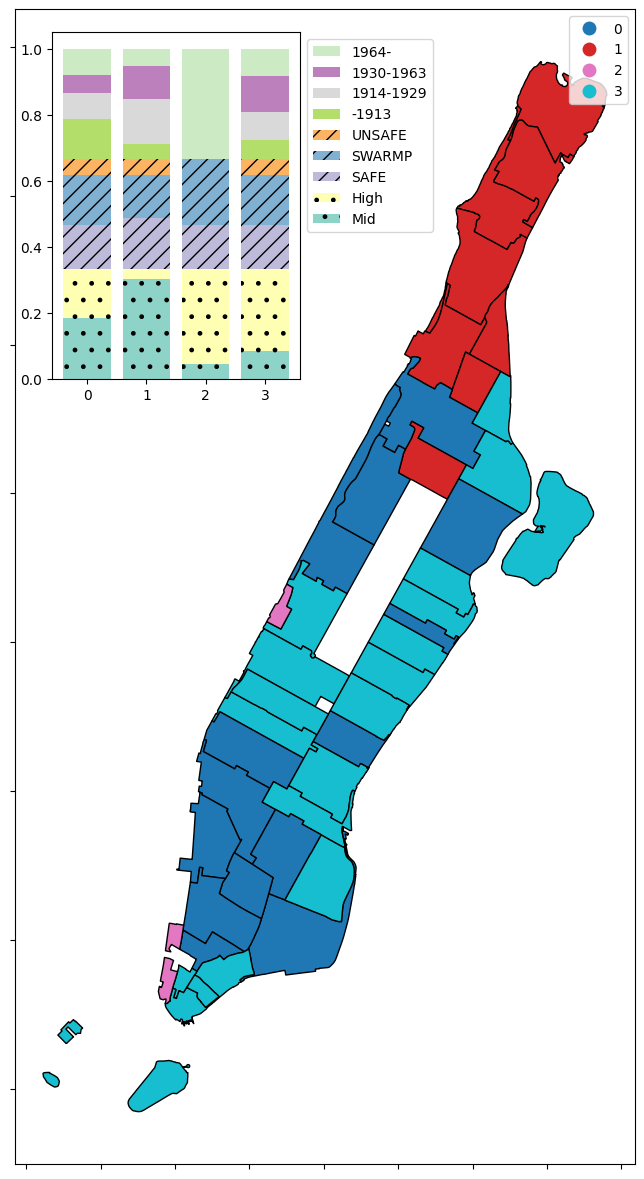

In [4]:
path = '/content/drive/MyDrive/2022_Facade Report Analysis/2022_Overview Of NYC FISP reports/Clustering/archive/Feature_cluster_0301_withBuildNum.csv'
# path = '/content/drive/MyDrive/2023 Spring/Other/2022_Overview Of NYC FISP reports/Clustering/archive/Feature_cluster_0301_withBuildNum.csv'
Feature1 = pd.read_csv(path,index_col='ZIPCODE')
#exclude facadetype
FacadeType = ['Brick masonry', 'Cast iron', 'Concrete', 'Glass', 'Metal and glass', 'Stone limestone','BIN']
selected_col = list(set(Feature1.columns) - set(FacadeType))
FeatureNorm = Feature1[selected_col]

rr = GaussianMixture(n_components = 4, random_state = 0).fit(FeatureNorm)
rr.labels_ = rr.predict(FeatureNorm) #get labels
clust={FeatureNorm.index[i]:rr.labels_[i] for i in range(len(rr.labels_))}
res=pd.DataFrame({'zipcode':FeatureNorm.index, 'label':rr.labels_})
# res.to_csv('Gaussian_YearQuantile_4Clust.csv',index=False)

clusterChar = FeatureNorm.reset_index().merge(res,left_on='ZIPCODE',right_on='zipcode').\
                    groupby(['label']).sum().reset_index()

#normalize by total cluster activity
clusterChar = clusterChar[[col for col in clusterChar.columns if col not in ['label','ZIPCODE','zipcode']]]
clusterChar = clusterChar.div(clusterChar.sum(axis=1), axis=0)
clusterChar['label'] = [i for i in range(4)]

res['label'] = res['label'].astype(str)

fig,ax = plt.subplots(nrows=1, ncols=1,figsize=(15,15))
plt.rcParams["figure.autolayout"] = True
zips.merge(res,left_on='ZIPCODE',right_on='zipcode').plot(column='label',  #cmap='cool',
                                    legend=True,ax=ax,edgecolor='black')

ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)

ins = ax.inset_axes([0.06,0.68,0.4,0.3])
NUM_COLORS = len(clusterChar.columns)
#camp reference: https://matplotlib.org/stable/gallery/color/colormap_reference.html
cm = plt.cm.get_cmap('Set3', NUM_COLORS)

ins.set_prop_cycle(color = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
bot = np.zeros(4)

cluster_num = 4
col_order = ['Mid', 'High', 'SAFE', 'SWARMP', 'UNSAFE', '-1913', '1914-1929', '1930-1963', '1964-']

for col in col_order:
    values = clusterChar[col].values
    if col in ['SWARMP','SAFE','UNSAFE']:  #filing status uses hatching pattern,
        ins.bar([i for i in range(cluster_num)], values, bottom = bot, label=col, hatch='//')
    elif col in ['Mid', 'High']: #building height uses dot pattern:
        ins.bar([i for i in range(cluster_num)], values, bottom = bot, label=col, hatch='.')
    else:  #year info uses color block,
        ins.bar([i for i in range(cluster_num)], values, bottom = bot, label=col)
    bot = bot + values

ins.set_xticks([i for i in range(cluster_num)])
handles, labels = ins.get_legend_handles_labels()
order = [i for i in range(len(col_order)-1,0-1,-1)]
ins.legend(bbox_to_anchor=(1.0, 1.0), handles=[handles[idx] for idx in order], labels=[labels[idx] for idx in order])

plt.show()

<ipython-input-7-e2c26300e9fa>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('Set3', NUM_COLORS)


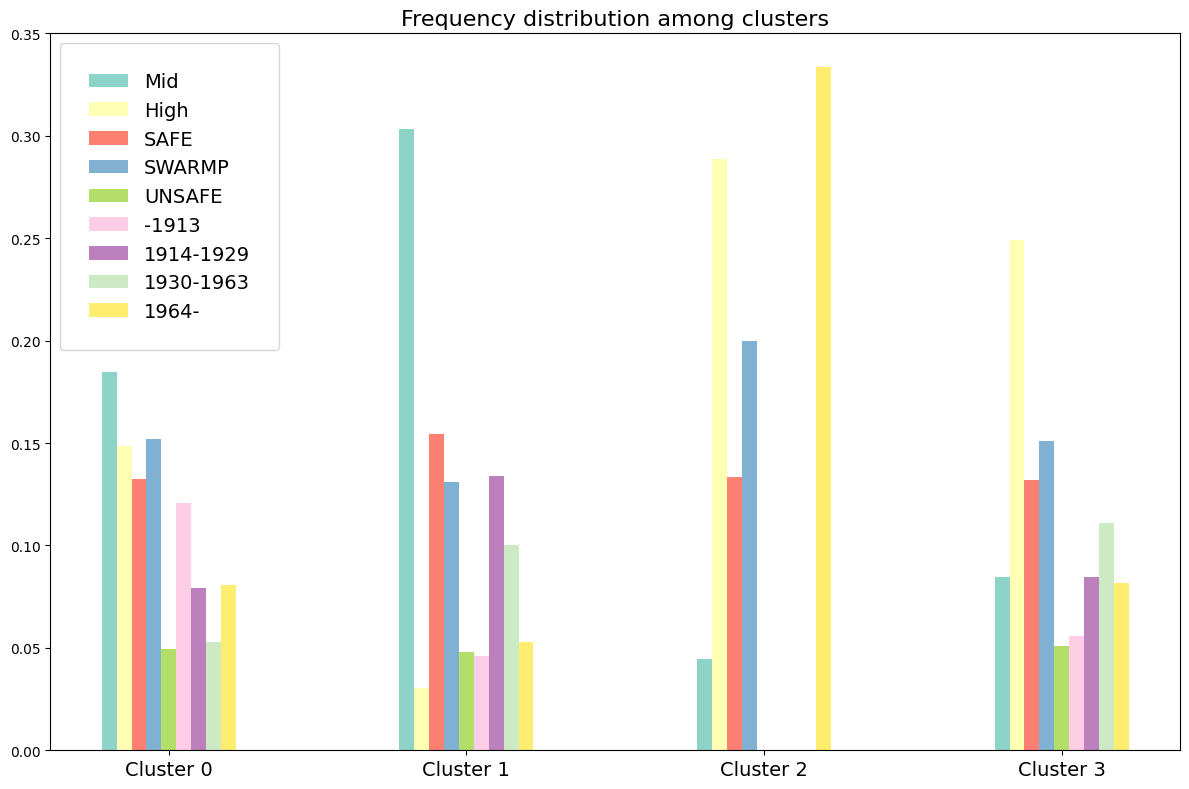

In [ ]:
#fequency distribution (run the cell above first)
fig, ax = plt.subplots(figsize=(12,8))
ind = np.arange(0,8,2)
width = 0.1

#set color
col_order = ['Mid', 'High', 'SAFE', 'SWARMP', 'UNSAFE', '-1913', '1914-1929', '1930-1963', '1964-']
NUM_COLORS = len(col_order)
cm = plt.cm.get_cmap('Set3', NUM_COLORS)
ax.set_prop_cycle(color = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

for col in col_order:
    values = clusterChar[col].values
    ax.bar(ind, values, width, bottom=0, label=col)
    ind = ind + width

ax.set_title('Frequency distribution among clusters', fontsize=16)
ax.set_xticks(ind - width*5, labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'], fontsize=14)

plt.legend(loc='upper left', borderpad=1.5, prop={'size': 14})

## Defect Visualize

In [3]:
##modify

zips_MA = zips.merge(res,left_on='ZIPCODE',right_on='zipcode')
zips_MA = zips_MA[['zipcode','POPULATION','geometry','label']]
zips_MA = zips_MA.rename(columns={'label':'label_first'})

#add num

# path = '/content/drive/MyDrive/2023 Spring/Other/2022_Overview Of NYC FISP reports/Clustering/archive/bin_zipcode.csv'
path = '/content/drive/MyDrive/2022_Facade Report Analysis/2022_Overview Of NYC FISP reports/Clustering/bin_zipcode.csv'
bin_zip = pd.read_csv(path).iloc[:,1:]
bin_zip = bin_zip.groupby('ZIPCODE').count()[['BIN']]
zips_MA = zips_MA.merge(bin_zip, right_on='ZIPCODE',left_on='zipcode')
zips_MA['coords'] = zips_MA['geometry'].apply(lambda x: x.representative_point().coords[:])
zips_MA['coords'] = [coords[0] for coords in zips_MA['coords']]


# path = '/content/drive/MyDrive/2022_Facade Report Analysis/2022_Overview Of NYC FISP reports/Clustering/archive/cluster_defe_MA_0307.csv'
# path = '/content/drive/MyDrive/2023 Spring/Other/2022_Overview Of NYC FISP reports/Clustering/archive/cluster_defe_MA_0404.csv'
path = '/content/drive/MyDrive/2022_Facade Report Analysis/2022_Overview Of NYC FISP reports/Clustering/archive/cluster_defe_MA_0404.csv'
clustDefe = pd.read_csv(path)
clustDefe = clustDefe.set_index('ZIPCODE')

#run the cluster in zipcode first (run the section above first)
cluster_result = res.copy()

#multiple plot
fig,ax = plt.subplots(nrows=1, ncols=4,figsize=(25,10))
plt.rcParams["figure.autolayout"] = True

ax_idx = 0
for i in cluster_result.label.unique():
    ziplist = cluster_result[cluster_result.label==i].zipcode.tolist()
    clustDefe1 = clustDefe[clustDefe.index.isin(ziplist)]

    # score for evaluation
    range_n_clusters = [2, 3, 4, 5, 6, 7]
    #initialize
    opt_clust = -1
    opt_score = -99
    for n_clusters in range_n_clusters: #try different numbers of clusters
        if len(clustDefe1) > n_clusters:
            rr = GaussianMixture(n_components = n_clusters, random_state = 0).fit(clustDefe1)
            rr.labels_ = rr.predict(clustDefe1)
            #report average Silhouette score
            silhouette_avg = silhouette_score(clustDefe1, rr.labels_)
            # print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))
            if silhouette_avg > opt_score:
                opt_score = silhouette_avg
                opt_clust = n_clusters
    print("For Cluster {},".format(i)+" the optimal cluster number is :{}".format(opt_clust))
    cluster_num = opt_clust

    ########generate clustering algorithm in the defect cluster
    rr = GaussianMixture(n_components = cluster_num, random_state = 0).fit(clustDefe1)
    rr.labels_ = rr.predict(clustDefe1) #get labels
    clust={clustDefe1.index[i]:rr.labels_[i] for i in range(len(rr.labels_))}
    res1=pd.DataFrame({'zipcode':clustDefe1.index, 'label':rr.labels_})
    # res.to_csv('Gaussian_YearQuantile_4Clust.csv',index=False)

    clusterChar = clustDefe1.reset_index().merge(res1,left_on='ZIPCODE',right_on='zipcode').\
                        groupby(['label']).sum().reset_index()

    #normalize by total cluster activity
    clusterChar = clusterChar[[col for col in clusterChar.columns if col not in ['label','ZIPCODE','zipcode']]]
    clusterChar = clusterChar.div(clusterChar.sum(axis=1), axis=0)
    clusterChar['label'] = [i for i in range(cluster_num)]
    res1['label'] = res1['label'].astype(str)

    zips_MA.merge(res1,on='zipcode',how='left').plot(column='label', #cmap='cool',
                                            legend=True,ax=ax[ax_idx],edgecolor='black',
                                            legend_kwds={'loc':'lower right'}, missing_kwds={
                                                            "color": "lightgrey", ## what to do with missing values
                                                            "edgecolor": "black",
                                                            "linewidth": 2,
                                                            "alpha": 0.5,
                                                            "hatch": "///",
                                                            "label": "Other Clusters",
                                                            },)
    ax[ax_idx].xaxis.set_tick_params(labelbottom=False)
    ax[ax_idx].yaxis.set_tick_params(labelleft=False)


    ###########plot proportion
    ins = ax[ax_idx].inset_axes([0.07,0.68,0.4,0.3])
    NUM_COLORS = len(clusterChar.columns)
    cm = plt.cm.get_cmap('tab20b', NUM_COLORS)

    ins.set_prop_cycle(color = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
    bot = np.zeros(cluster_num)

    for col in clusterChar.columns:
        if col != 'label':
            values = clusterChar[col].values
            if col in ['displacement','deflection','slippage', 'bowing/bulging']:  #filing status uses hatching pattern,
                ins.bar([i for i in range(cluster_num)], values, bottom = bot, label=col, hatch='..')
            elif col in ['repair failure', 'loose','fastener failure','failure','coating failure/peeling/flaking','separation']: #building height uses dot pattern:
                ins.bar([i for i in range(cluster_num)], values, bottom = bot, label=col, hatch='xx')
            elif col in ['crack', 'erosion/pitting','abrasion','chipping','scaling','spall','delamination','cavity']: #building height uses dot pattern:
                ins.bar([i for i in range(cluster_num)], values, bottom = bot, label=col, hatch='///')
            elif col in ['hollow','honeycomb']: #building height uses dot pattern:
                ins.bar([i for i in range(cluster_num)], values, bottom = bot, label=col, hatch='++')
            else:  #year info uses color block,
                ins.bar([i for i in range(cluster_num)], values, bottom = bot, label=col)
            bot = bot + values

    ins.set_xticks([i for i in range(cluster_num)])
    handles, labels = ins.get_legend_handles_labels()
    order = [i for i in range(len(clusterChar.columns)-2,0-1,-1)]
    # ins.legend(bbox_to_anchor=(1.0, 1.5, 0.5, 0.5), handles=[handles[idx] for idx in order], labels=[labels[idx] for idx in order])


    #####Add extra information: cluster number
    import math
    LabelList = zips_MA.merge(res1,on='zipcode',how='left').label.astype('float').tolist()
    for idx, row in zips_MA.iterrows():
        if not math.isnan(LabelList[idx]):
            ax[ax_idx].annotate(text=row['BIN'], xy=row['coords'], horizontalalignment='center', color='black')
    ax[ax_idx].set_title('Cluster {}'.format(i))
    ax_idx +=1

ins.legend(bbox_to_anchor=(3.3, -0.6, 0.5, 0.5), handles=[handles[idx] for idx in order], labels=[labels[idx] for idx in order]).figure
plt.show()
plt.savefig('defectClust_clust.png')

NameError: ignored

### Radar Chart

For Cluster 0, the optimal cluster number is :3
['abrasion', 'bowing/bulging', 'cavity', 'chipping', 'coating failure/peeling/flaking', 'crack', 'crazing', 'deflection', 'degradation', 'delamination', 'displacement', 'efflorescence', 'erosion/pitting', 'failure', 'hollow', 'leakage', 'loose', 'repair failure', 'rust/corrosion', 'scaling', 'separation', 'slippage', 'spall', 'staining'] 24 24 24
For Cluster 3, the optimal cluster number is :2
['abrasion', 'bowing/bulging', 'cavity', 'chipping', 'coating failure/peeling/flaking', 'crack', 'crazing', 'deflection', 'degradation', 'delamination', 'displacement', 'efflorescence', 'erosion/pitting', 'failure', 'fastener failure', 'hollow', 'leakage', 'loose', 'repair failure', 'rust/corrosion', 'scaling', 'separation', 'slippage', 'spall', 'staining'] 25 25 25
For Cluster 1, the optimal cluster number is :2
['abrasion', 'bowing/bulging', 'cavity', 'chipping', 'coating failure/peeling/flaking', 'crack', 'crazing', 'deflection', 'degradation', '

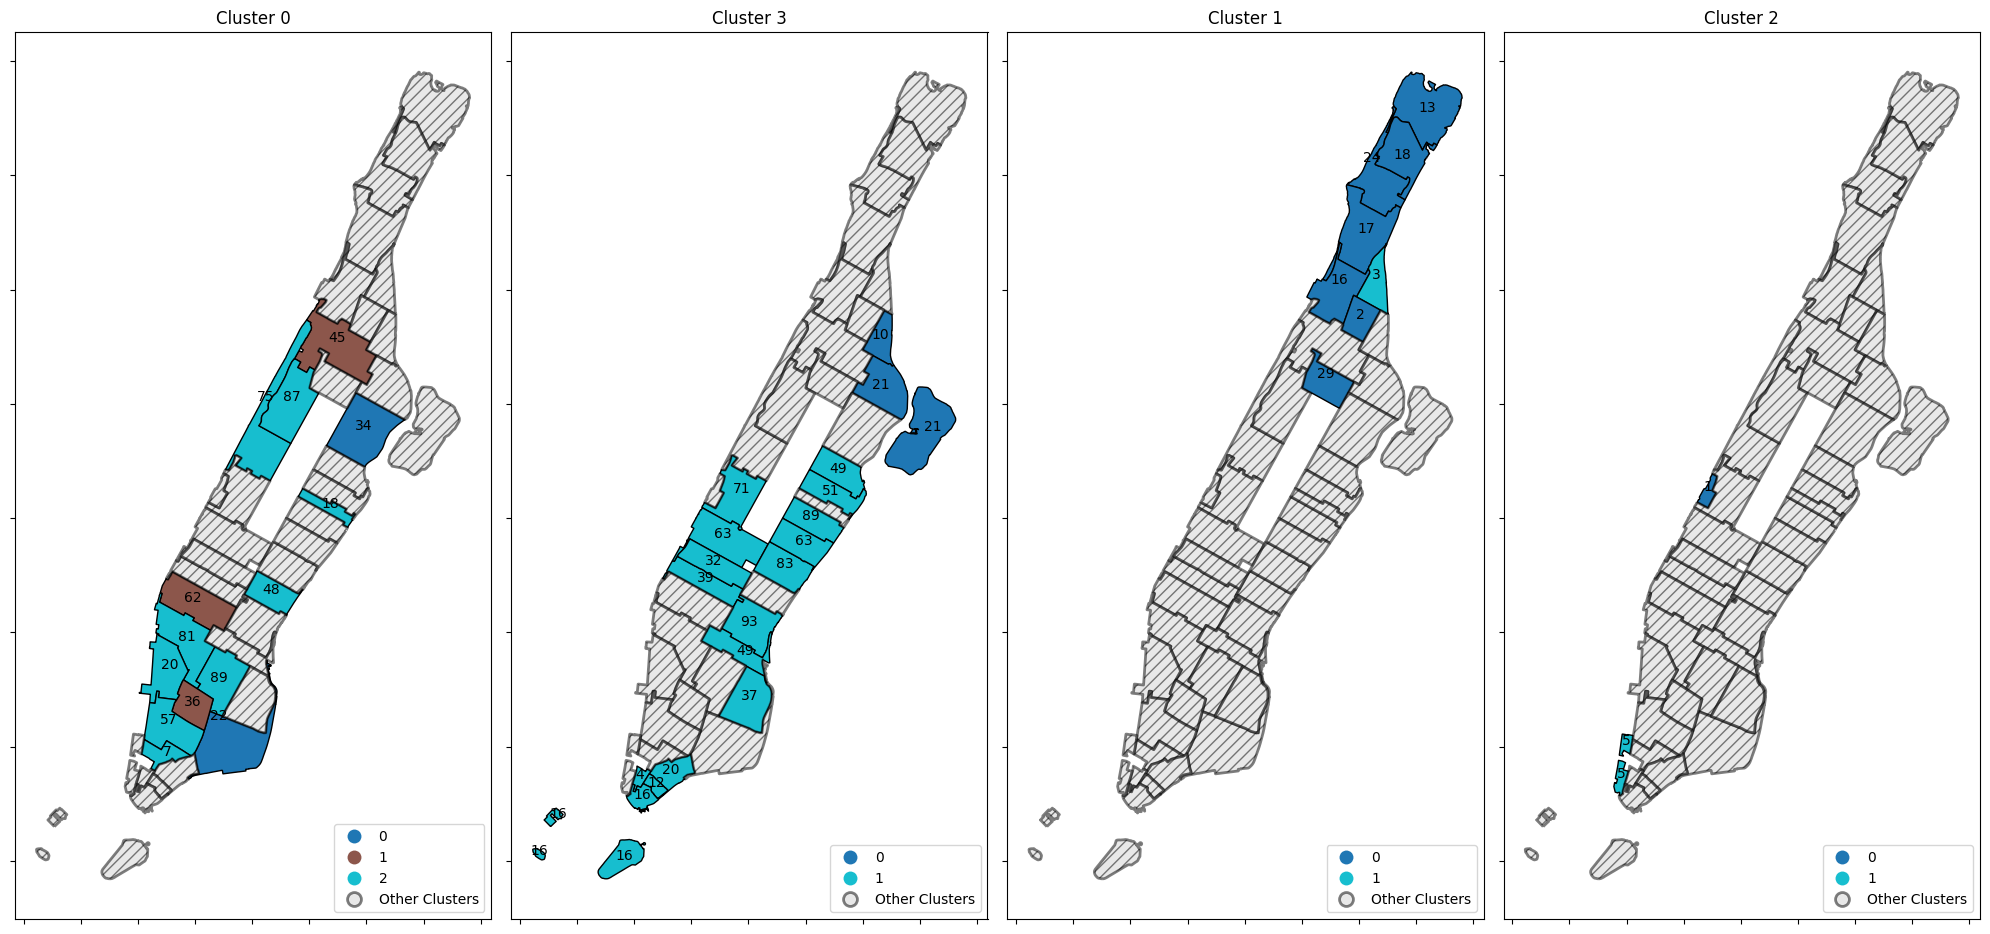

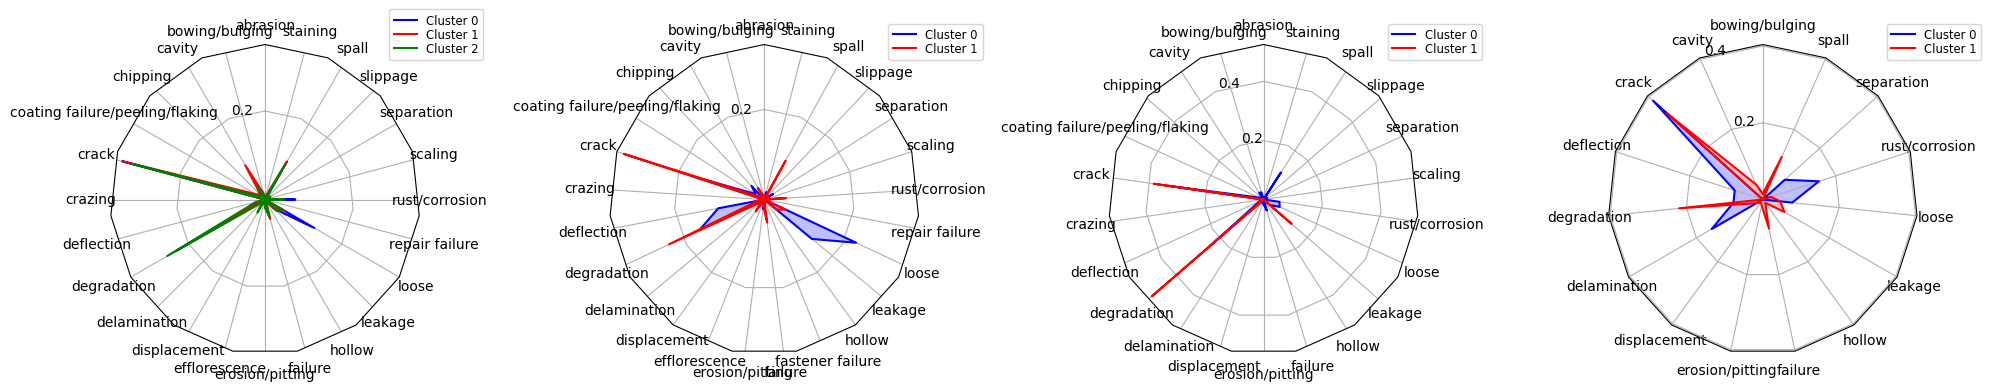

In [ ]:
##modify

zips_MA = zips.merge(res,left_on='ZIPCODE',right_on='zipcode')
zips_MA = zips_MA[['zipcode','POPULATION','geometry','label']]
zips_MA = zips_MA.rename(columns={'label':'label_first'})

#add num
path = '/content/drive/MyDrive/2023 Spring/Other/2022_Overview Of NYC FISP reports/Clustering/archive/bin_zipcode.csv'
bin_zip = pd.read_csv(path).iloc[:,1:]
bin_zip = bin_zip.groupby('ZIPCODE').count()[['BIN']]
zips_MA = zips_MA.merge(bin_zip, right_on='ZIPCODE',left_on='zipcode')
zips_MA['coords'] = zips_MA['geometry'].apply(lambda x: x.representative_point().coords[:])
zips_MA['coords'] = [coords[0] for coords in zips_MA['coords']]


# path = '/content/drive/MyDrive/2022_Facade Report Analysis/2022_Overview Of NYC FISP reports/Clustering/archive/cluster_defe_MA_0307.csv'
path = '/content/drive/MyDrive/2023 Spring/Other/2022_Overview Of NYC FISP reports/Clustering/archive/cluster_defe_MA_0404.csv'
clustDefe = pd.read_csv(path)
clustDefe = clustDefe.set_index('ZIPCODE')

#run the cluster in zipcode first (run the section above first)
cluster_result = res.copy()

#multiple plot
fig,ax = plt.subplots(nrows=1, ncols=4,figsize=(20,10))
rad, ax_rad = plt.subplots(nrows=1, ncols=4,subplot_kw=dict(projection='radar'),figsize=(20,10))
plt.rcParams["figure.autolayout"] = True

ax_idx = 0
for i in cluster_result.label.unique():
    ziplist = cluster_result[cluster_result.label==i].zipcode.tolist()
    clustDefe1 = clustDefe[clustDefe.index.isin(ziplist)]

    # score for evaluation
    range_n_clusters = [2, 3, 4, 5, 6, 7]
    #initialize
    opt_clust = -1
    opt_score = -99
    for n_clusters in range_n_clusters: #try different numbers of clusters
        if len(clustDefe1) > n_clusters:
            rr = GaussianMixture(n_components = n_clusters, random_state = 0).fit(clustDefe1)
            rr.labels_ = rr.predict(clustDefe1)
            #report average Silhouette score
            silhouette_avg = silhouette_score(clustDefe1, rr.labels_)
            # print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))
            if silhouette_avg > opt_score:
                opt_score = silhouette_avg
                opt_clust = n_clusters
    print("For Cluster {},".format(i)+" the optimal cluster number is :{}".format(opt_clust))
    cluster_num = opt_clust

    ########generate clustering algorithm in the defect cluster
    rr = GaussianMixture(n_components = cluster_num, random_state = 0).fit(clustDefe1)
    rr.labels_ = rr.predict(clustDefe1) #get labels
    clust={clustDefe1.index[i]:rr.labels_[i] for i in range(len(rr.labels_))}
    res1=pd.DataFrame({'zipcode':clustDefe1.index, 'label':rr.labels_})
    # res.to_csv('Gaussian_YearQuantile_4Clust.csv',index=False)

    clusterChar = clustDefe1.reset_index().merge(res1,left_on='ZIPCODE',right_on='zipcode').\
                        groupby(['label']).sum().reset_index()

    #normalize by total cluster activity
    clusterChar = clusterChar[[col for col in clusterChar.columns if col not in ['label','ZIPCODE','zipcode']]]
    clusterChar = clusterChar.div(clusterChar.sum(axis=1), axis=0)
    clusterChar['label'] = [i for i in range(cluster_num)]
    res1['label'] = res1['label'].astype(str)

    zips_MA.merge(res1,on='zipcode',how='left').plot(column='label', #cmap='cool',
                                            legend=True,ax=ax[ax_idx],edgecolor='black',
                                            legend_kwds={'loc':'lower right'}, missing_kwds={
                                                            "color": "lightgrey", ## what to do with missing values
                                                            "edgecolor": "black",
                                                            "linewidth": 2,
                                                            "alpha": 0.5,
                                                            "hatch": "///",
                                                            "label": "Other Clusters",
                                                            },)
    ax[ax_idx].xaxis.set_tick_params(labelbottom=False)
    ax[ax_idx].yaxis.set_tick_params(labelleft=False)

    #####Add extra information: cluster number
    import math
    LabelList = zips_MA.merge(res1,on='zipcode',how='left').label.astype('float').tolist()
    for idx, row in zips_MA.iterrows():
        if not math.isnan(LabelList[idx]):
            ax[ax_idx].annotate(text=row['BIN'], xy=row['coords'], horizontalalignment='center', color='black')
    ax[ax_idx].set_title('Cluster {}'.format(i))


    ######## radar
    clusterChar = clusterChar.loc[:, clusterChar.columns!='label']
    ##filter out data not display in proportion
    filterCol = []
    filterVal = []
    for col, val in zip(clusterChar.columns.tolist(), np.array(clusterChar.values.tolist()).T):
        if not val.any(0):
            pass
        else:
            filterCol.append(col)
            filterVal.append(val.tolist())
    filterVal = np.array(filterVal).T.tolist()

    N = len(filterCol)
    theta = radar_factory(N, frame='polygon')
    data = [filterCol, ('Cluster',filterVal)]

    spoke_labels = data.pop(0)
    # print(spoke_labels, len(spoke_labels),N, len(filterVal[0]))
    # rad, ax_rad[ax_idx] = plt.subplots(subplot_kw=dict(projection='radar'))
    colors = ['b', 'r', 'g', 'm', 'y']

    for (title, case_data) in data:
        ax_rad[ax_idx].set_rgrids([0.2, 0.4, 0.6, 0.8])
        for d, color in zip(case_data, colors):
            ax_rad[ax_idx].plot(theta, d, color=color)
            ax_rad[ax_idx].fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')

        # ax_rad[ax_idx].set_varlabels(spoke_labels)
        ax_rad[ax_idx].set_thetagrids(np.degrees(theta), spoke_labels)

    # add legend relative to top-left plot
    labels = ['Cluster '+str(i) for i in range(len(clusterChar))]
    legend = ax_rad[ax_idx].legend(labels, loc=(0.9, .95),
                                labelspacing=0.1, fontsize='small')

    ax_idx +=1


# ins.legend(bbox_to_anchor=(3.3, -0.6, 0.5, 0.5), handles=[handles[idx] for idx in order], labels=[labels[idx] for idx in order]).figure
plt.show()
# fig.savefig('temp.png', dpi=fig.dpi)

In [ ]:

for col, val in zip(clusterChar.columns.tolist(), np.array(clusterChar.values.tolist()).T):
    if len(val[np.where( (val > 0.001) )]) >= 1:
        # print(col, val, val[np.where( (val > 0.001) )])
        pass
    else:
        print(col, val, val[np.where( (val > 0.001) )])

abrasion [0. 0.] []
chipping [0. 0.] []
coating failure/peeling/flaking [0. 0.] []
crazing [0. 0.] []
efflorescence [0. 0.] []
fastener failure [0. 0.] []
repair failure [0. 0.] []
scaling [0. 0.] []
slippage [0. 0.] []
staining [0. 0.] []


For Cluster 0, the optimal cluster number is :3
For Cluster 3, the optimal cluster number is :2
For Cluster 1, the optimal cluster number is :2
For Cluster 2, the optimal cluster number is :2


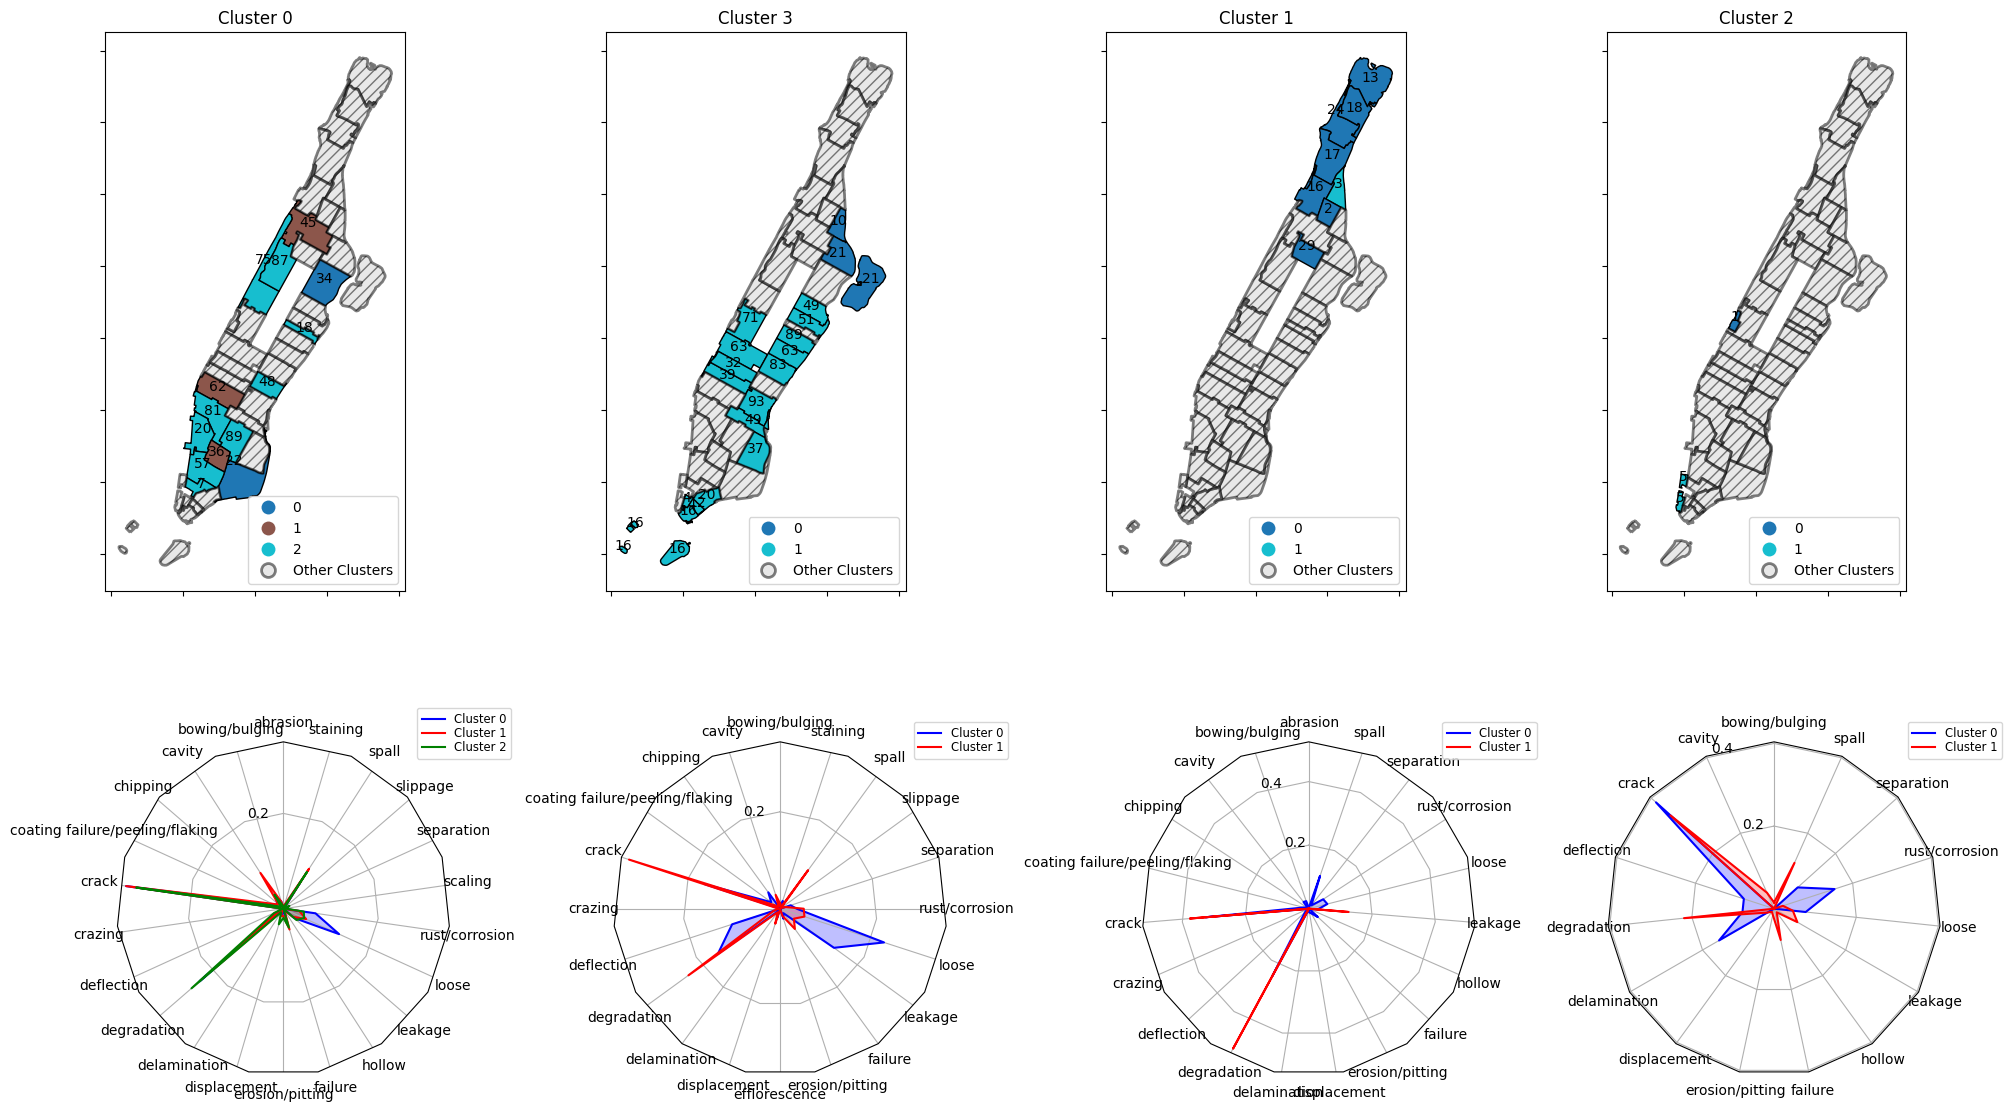

In [ ]:
##modify

zips_MA = zips.merge(res,left_on='ZIPCODE',right_on='zipcode')
zips_MA = zips_MA[['zipcode','POPULATION','geometry','label']]
zips_MA = zips_MA.rename(columns={'label':'label_first'})

#add num
path = '/content/drive/MyDrive/2023 Spring/Other/2022_Overview Of NYC FISP reports/Clustering/archive/bin_zipcode.csv'
bin_zip = pd.read_csv(path).iloc[:,1:]
bin_zip = bin_zip.groupby('ZIPCODE').count()[['BIN']]
zips_MA = zips_MA.merge(bin_zip, right_on='ZIPCODE',left_on='zipcode')
zips_MA['coords'] = zips_MA['geometry'].apply(lambda x: x.representative_point().coords[:])
zips_MA['coords'] = [coords[0] for coords in zips_MA['coords']]


# path = '/content/drive/MyDrive/2022_Facade Report Analysis/2022_Overview Of NYC FISP reports/Clustering/archive/cluster_defe_MA_0307.csv'
path = '/content/drive/MyDrive/2023 Spring/Other/2022_Overview Of NYC FISP reports/Clustering/archive/cluster_defe_MA_0404.csv'
clustDefe = pd.read_csv(path)
clustDefe = clustDefe.set_index('ZIPCODE')

#run the cluster in zipcode first (run the section above first)
cluster_result = res.copy()

#multiple plot
mainfig = plt.figure(constrained_layout=True,figsize=(20,12))
mainax = mainfig.subfigures(2,1)
ax = mainax[0].subplots(nrows=1, ncols=4)
ax_rad = mainax[1].subplots(nrows=1, ncols=4,subplot_kw=dict(projection='radar'))
plt.rcParams["figure.autolayout"] = True

ax_idx = 0
for i in cluster_result.label.unique():
    ziplist = cluster_result[cluster_result.label==i].zipcode.tolist()
    clustDefe1 = clustDefe[clustDefe.index.isin(ziplist)]

    # score for evaluation
    range_n_clusters = [2, 3, 4, 5, 6, 7]
    #initialize
    opt_clust = -1
    opt_score = -99
    for n_clusters in range_n_clusters: #try different numbers of clusters
        if len(clustDefe1) > n_clusters:
            rr = GaussianMixture(n_components = n_clusters, random_state = 0).fit(clustDefe1)
            rr.labels_ = rr.predict(clustDefe1)
            #report average Silhouette score
            silhouette_avg = silhouette_score(clustDefe1, rr.labels_)
            # print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))
            if silhouette_avg > opt_score:
                opt_score = silhouette_avg
                opt_clust = n_clusters
    print("For Cluster {},".format(i)+" the optimal cluster number is :{}".format(opt_clust))
    cluster_num = opt_clust

    ########generate clustering algorithm in the defect cluster
    rr = GaussianMixture(n_components = cluster_num, random_state = 0).fit(clustDefe1)
    rr.labels_ = rr.predict(clustDefe1) #get labels
    clust={clustDefe1.index[i]:rr.labels_[i] for i in range(len(rr.labels_))}
    res1=pd.DataFrame({'zipcode':clustDefe1.index, 'label':rr.labels_})
    # res.to_csv('Gaussian_YearQuantile_4Clust.csv',index=False)

    clusterChar = clustDefe1.reset_index().merge(res1,left_on='ZIPCODE',right_on='zipcode').\
                        groupby(['label']).sum().reset_index()

    #normalize by total cluster activity
    clusterChar = clusterChar[[col for col in clusterChar.columns if col not in ['label','ZIPCODE','zipcode']]]
    clusterChar = clusterChar.div(clusterChar.sum(axis=1), axis=0)
    clusterChar['label'] = [i for i in range(cluster_num)]
    res1['label'] = res1['label'].astype(str)

    zips_MA.merge(res1,on='zipcode',how='left').plot(column='label', #cmap='cool',
                                            legend=True,ax=ax[ax_idx],edgecolor='black',
                                            legend_kwds={'loc':'lower right'}, missing_kwds={
                                                            "color": "lightgrey", ## what to do with missing values
                                                            "edgecolor": "black",
                                                            "linewidth": 2,
                                                            "alpha": 0.5,
                                                            "hatch": "///",
                                                            "label": "Other Clusters",
                                                            },)
    ax[ax_idx].xaxis.set_tick_params(labelbottom=False)
    ax[ax_idx].yaxis.set_tick_params(labelleft=False)


    #####Add extra information: cluster number
    import math
    LabelList = zips_MA.merge(res1,on='zipcode',how='left').label.astype('float').tolist()
    for idx, row in zips_MA.iterrows():
        if not math.isnan(LabelList[idx]):
            ax[ax_idx].annotate(text=row['BIN'], xy=row['coords'], horizontalalignment='center', color='black')
    ax[ax_idx].set_title('Cluster {}'.format(i))


    ######## radar
    clusterChar = clusterChar.loc[:, clusterChar.columns!='label']
    ##filter out data not display in proportion
    filterCol = []
    filterVal = []
    for col, val in zip(clusterChar.columns.tolist(), np.array(clusterChar.values.tolist()).T):
        if len(val[np.where( (val > 0.001) )]) >= 1:
            filterCol.append(col)
            filterVal.append(val.tolist())
    filterVal = np.array(filterVal).T.tolist()

    N = len(filterCol)
    theta = radar_factory(N, frame='polygon')
    data = [filterCol, ('Cluster',filterVal)]

    spoke_labels = data.pop(0)
    colors = ['b', 'r', 'g', 'm', 'y']

    for (title, case_data) in data:
        ax_rad[ax_idx].set_rgrids([0.2, 0.4, 0.6, 0.8])
        for d, color in zip(case_data, colors):
            ax_rad[ax_idx].plot(theta, d, color=color)
            ax_rad[ax_idx].fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')

        # ax_rad[ax_idx].set_varlabels(spoke_labels)
        ax_rad[ax_idx].set_thetagrids(np.degrees(theta), spoke_labels)

    # add legend relative to top-left plot
    labels = ['Cluster '+str(i) for i in range(len(clusterChar))]
    legend = ax_rad[ax_idx].legend(labels, loc=(0.9, .95),
                                labelspacing=0.1, fontsize='small')

    ax_idx +=1


plt.show()
# plt.savefig('defectClust_clust.png')
mainfig.savefig('temp_thres1e-03.png', dpi=mainfig.dpi)

In [ ]:
def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta



# if __name__ == '__main__':
#     N = 9
#     theta = radar_factory(N, frame='polygon')

#     data = example_data()
#     spoke_labels = data.pop(0)

#     fig, axs = plt.subplots(figsize=(18, 9), nrows=1, ncols=4,
#                             subplot_kw=dict(projection='radar'))
#     fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

#     colors = ['b', 'r', 'g', 'm', 'y']
#     # Plot the four cases from the example data on separate axes
#     for ax, (title, case_data) in zip(axs.flat, data):
#         ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
#         ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
#                      horizontalalignment='center', verticalalignment='center')
#         for d, color in zip(case_data, colors):
#             ax.plot(theta, d, color=color)
#             ax.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
#         ax.set_varlabels(spoke_labels)

#     # add legend relative to top-left plot
#     labels = ('Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5')
#     legend = axs[3].legend(labels, loc=(0.9, .95),
#                               labelspacing=0.1, fontsize='small')

#     fig.text(0.5, 0.965, '5-Factor Solution Profiles Across Four Scenarios',
#              horizontalalignment='center', color='black', weight='bold',
#              size='large')

#     plt.show()


### Defect Visualization in higher taxonomy

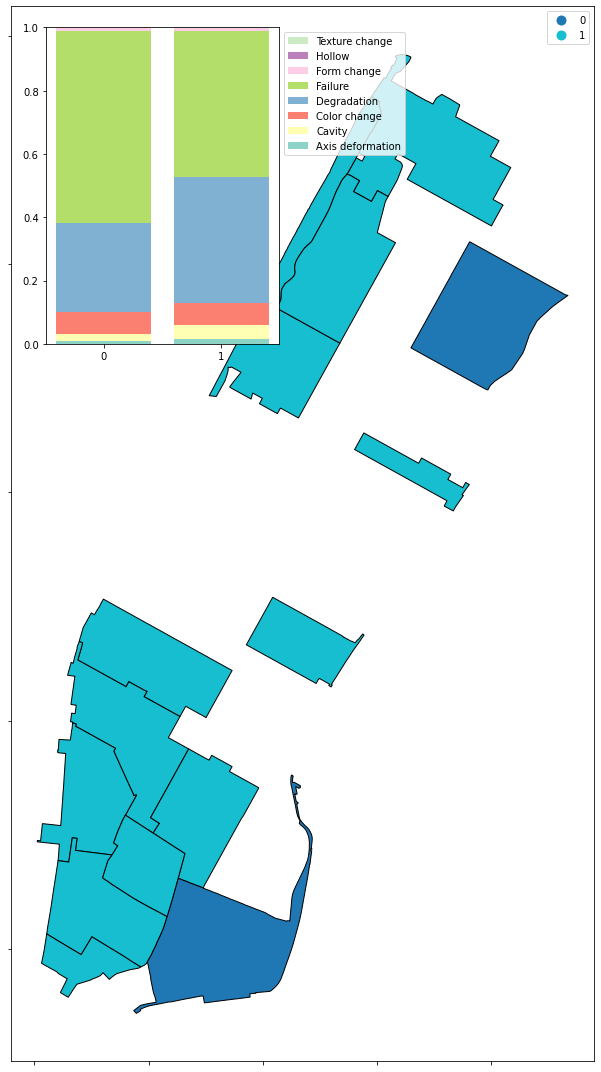

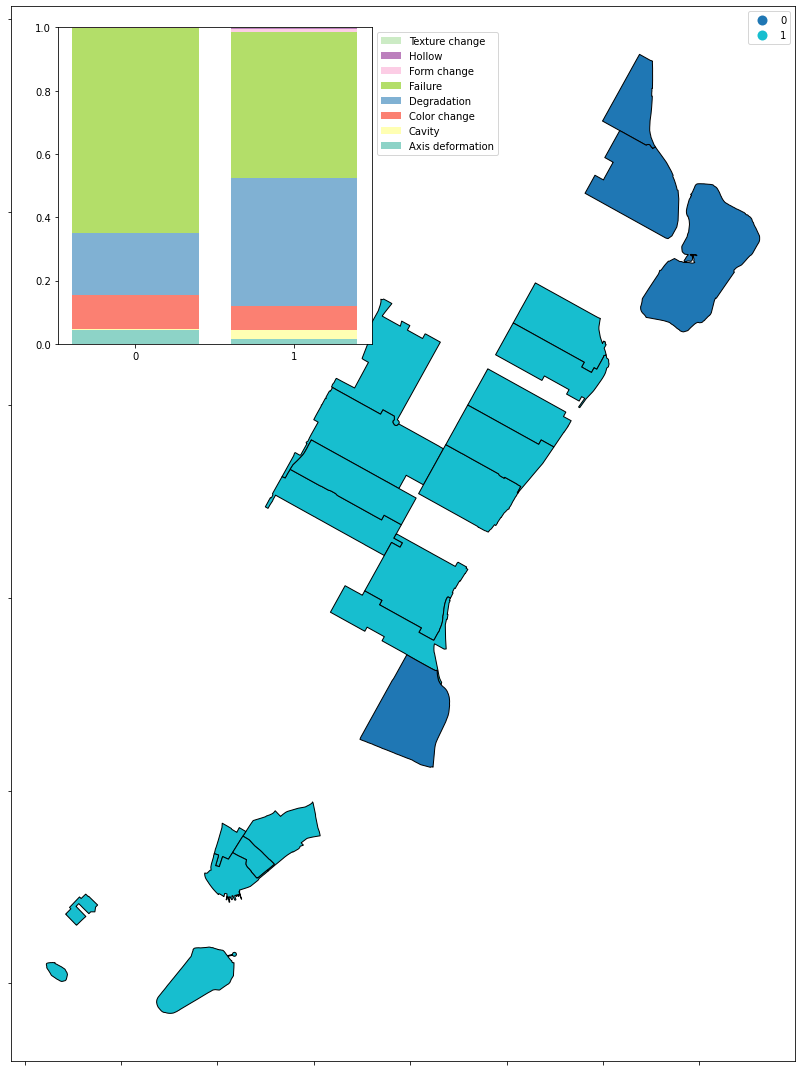

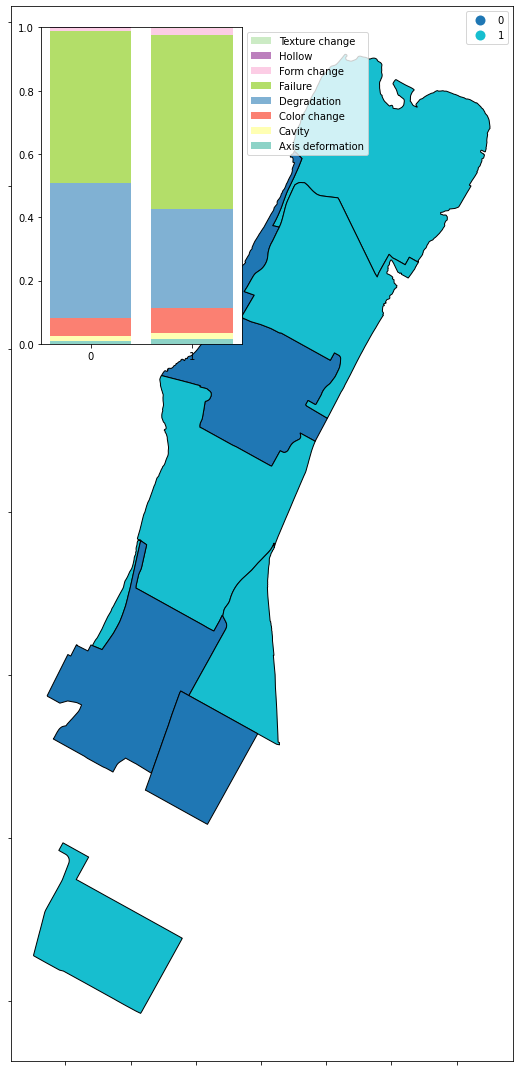

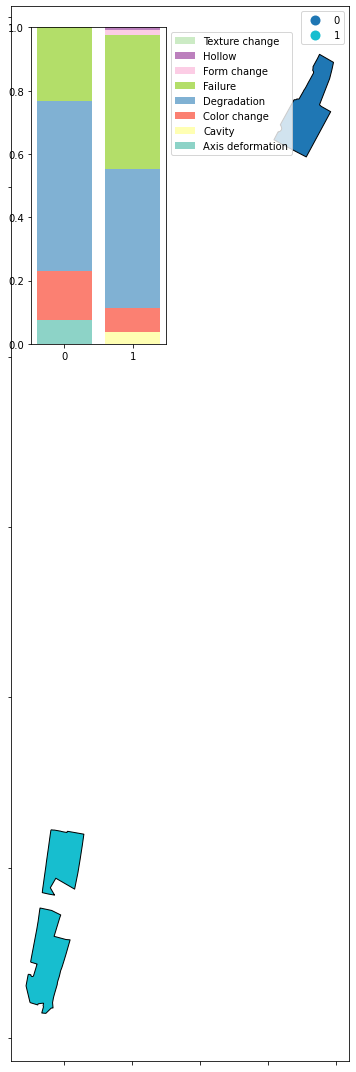

In [ ]:
path = '/content/drive/MyDrive/2023 Spring/Other/2022_Overview Of NYC FISP reports/Clustering/archive/cluster_defe_MA_0308.csv'
clustDefe = pd.read_csv(path)
clustDefe = clustDefe.set_index('ZIPCODE')

#run the cluster in zipcode first (run the section above first)
cluster_result = res.copy()
for i in cluster_result.label.unique():
    ziplist = cluster_result[cluster_result.label==i].zipcode.tolist()
    clustDefe1 = clustDefe[clustDefe.index.isin(ziplist)]

    cluster_num = 2
    rr = GaussianMixture(n_components = cluster_num, random_state = 0).fit(clustDefe1)
    rr.labels_ = rr.predict(clustDefe1) #get labels
    clust={clustDefe1.index[i]:rr.labels_[i] for i in range(len(rr.labels_))}
    res1=pd.DataFrame({'zipcode':clustDefe1.index, 'label':rr.labels_})

    clusterChar = clustDefe1.reset_index().merge(res1,left_on='ZIPCODE',right_on='zipcode').\
                        groupby(['label']).sum().reset_index()

    #normalize by total cluster activity
    clusterChar = clusterChar[[col for col in clusterChar.columns if col not in ['label','ZIPCODE','zipcode']]]
    clusterChar = clusterChar.div(clusterChar.sum(axis=1), axis=0)
    clusterChar['label'] = [i for i in range(cluster_num)]

    res1['label'] = res1['label'].astype(str)

    fig,ax = plt.subplots(nrows=1, ncols=1,figsize=(15,15))
    plt.rcParams["figure.autolayout"] = True
    zips.merge(res1,left_on='ZIPCODE',right_on='zipcode').plot(column='label',  #cmap='cool',
                                        legend=True,ax=ax,edgecolor='black')

    ax.xaxis.set_tick_params(labelbottom=False)
    ax.yaxis.set_tick_params(labelleft=False)

    ins = ax.inset_axes([0.06,0.68,0.4,0.3])
    NUM_COLORS = len(clusterChar.columns)
    #camp reference: https://matplotlib.org/stable/gallery/color/colormap_reference.html
    cm = plt.cm.get_cmap('Set3', NUM_COLORS)

    ins.set_prop_cycle(color = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
    bot = np.zeros(cluster_num)

    for col in clusterChar.columns:
        if col != 'label':
            values = clusterChar[col].values
            ins.bar([i for i in range(cluster_num)], values, bottom = bot, label=col)
            bot = bot + values

    ins.set_xticks([i for i in range(cluster_num)])
    handles, labels = ins.get_legend_handles_labels()
    order = [i for i in range(len(clusterChar.columns)-2,0-1,-1)]
    ins.legend(bbox_to_anchor=(1.0, 1.0), handles=[handles[idx] for idx in order], labels=[labels[idx] for idx in order])

    plt.show()

## Cluster Individual

/usr/local/lib/python3.9/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.9/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
<ipython-input-11-fa151990f53b>:10: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon, lat = transform(inProj,outProj,x,y)


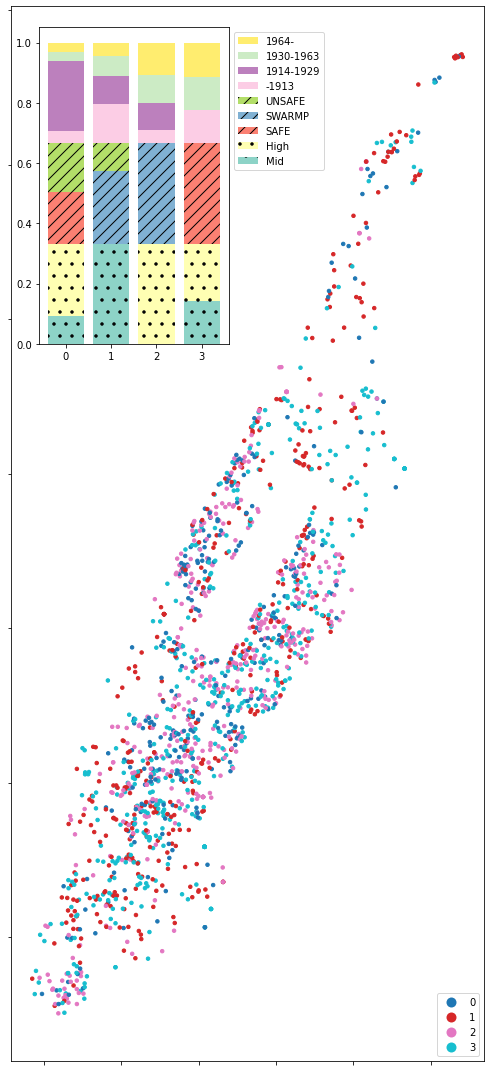

,BIN
label,
0,289
1,408
2,425
3,494


In [ ]:
path = '/content/drive/MyDrive/2023 Spring/Other/2022_Overview Of NYC FISP reports/Clustering/archive/individual_cluster_0306.csv'
path_dist = '/content/drive/MyDrive/2023 Spring/Other/2022_Overview Of NYC FISP reports/Clustering/archive/individual_clusterdist_0307.csv'
indi_data = pd.read_csv(path)

#convert projection system
inProj = Proj("+init=EPSG:4326",preserve_units=True) # WGS84 in degrees
outProj  = Proj("+init=EPSG:2263") #epsg:2263 The New York State Plane Long Island Zone

y,x=inProj(indi_data.Lat_y.values,indi_data.Lon_x.values)
lon, lat = transform(inProj,outProj,x,y)
#convert to geopadas dataframe
#crs: coordinate reference system
indi_data = gpd.GeoDataFrame(indi_data,
                geometry=gpd.points_from_xy(lon, lat, crs="EPSG:2263"))
indi_data.label = indi_data.label.astype('str')

##plotting
fig,ax = plt.subplots(nrows=1, ncols=1,figsize=(15,15))
plt.rcParams["figure.autolayout"] = True
indi_data.plot(column='label',ax=ax,markersize=12,legend=True,
               legend_kwds={'loc':'lower right','bbox_to_anchor':(0.5, 0, 0.5, 0.7)})

ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)

#plot histogram for distribution
clust_dist = pd.read_csv(path_dist)
clust_dist = clust_dist.set_index('label')
clust_dist = clust_dist.div(clust_dist.sum(axis=1), axis=0)
clust_dist.columns = list(map(lambda x: x.split('_')[1],clust_dist.columns))
ins = ax.inset_axes([0.06,0.68,0.4,0.3])
NUM_COLORS = len(clust_dist.columns)
#camp reference: https://matplotlib.org/stable/gallery/color/colormap_reference.html
cm = plt.cm.get_cmap('Set3', NUM_COLORS)

cluster_num = 4
ins.set_prop_cycle(color = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
bot = np.zeros(cluster_num)

col_order = ['Mid', 'High', 'SAFE', 'SWARMP', 'UNSAFE', '-1913', '1914-1929', '1930-1963', '1964-']

for col in col_order:
    values = clust_dist[col].values
    if col in ['SWARMP','SAFE','UNSAFE']:  #filing status uses hatching pattern,
        ins.bar([i for i in range(cluster_num)], values, bottom = bot, label=col, hatch='//')
    elif col in ['Mid', 'High']: #building height uses dot pattern:
        ins.bar([i for i in range(cluster_num)], values, bottom = bot, label=col, hatch='.')
    else:  #year info uses color block,
        ins.bar([i for i in range(cluster_num)], values, bottom = bot, label=col)
    bot = bot + values

ins.set_xticks([i for i in range(cluster_num)])
handles, labels = ins.get_legend_handles_labels()
order = [i for i in range(len(col_order)-1,0-1,-1)]
ins.legend(bbox_to_anchor=(1.0, 1.0), handles=[handles[idx] for idx in order], labels=[labels[idx] for idx in order])

plt.show()

#count the number of building in each cluster
indi_data[['BIN','label']].groupby('label').count()

In [ ]:
# ##evalute the cluster by score
# from sklearn.metrics import silhouette_samples, silhouette_score
# import matplotlib.cm as cm
# import numpy as np

# range_n_clusters = [2, 3, 4, 5, 6, 7]
# for n_clusters in range_n_clusters: #try different numbers of clusters
#     rr = KMeans(n_clusters = n_clusters, random_state = 0).fit(FeatureNorm)
#     rr.labels_ = rr.predict(FeatureNorm)
#     #report average Silhouette score
#     silhouette_avg = silhouette_score(FeatureNorm, rr.labels_)
#     print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

/usr/local/lib/python3.9/dist-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-32-60aa57689970>:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('Set3', NUM_COLORS)


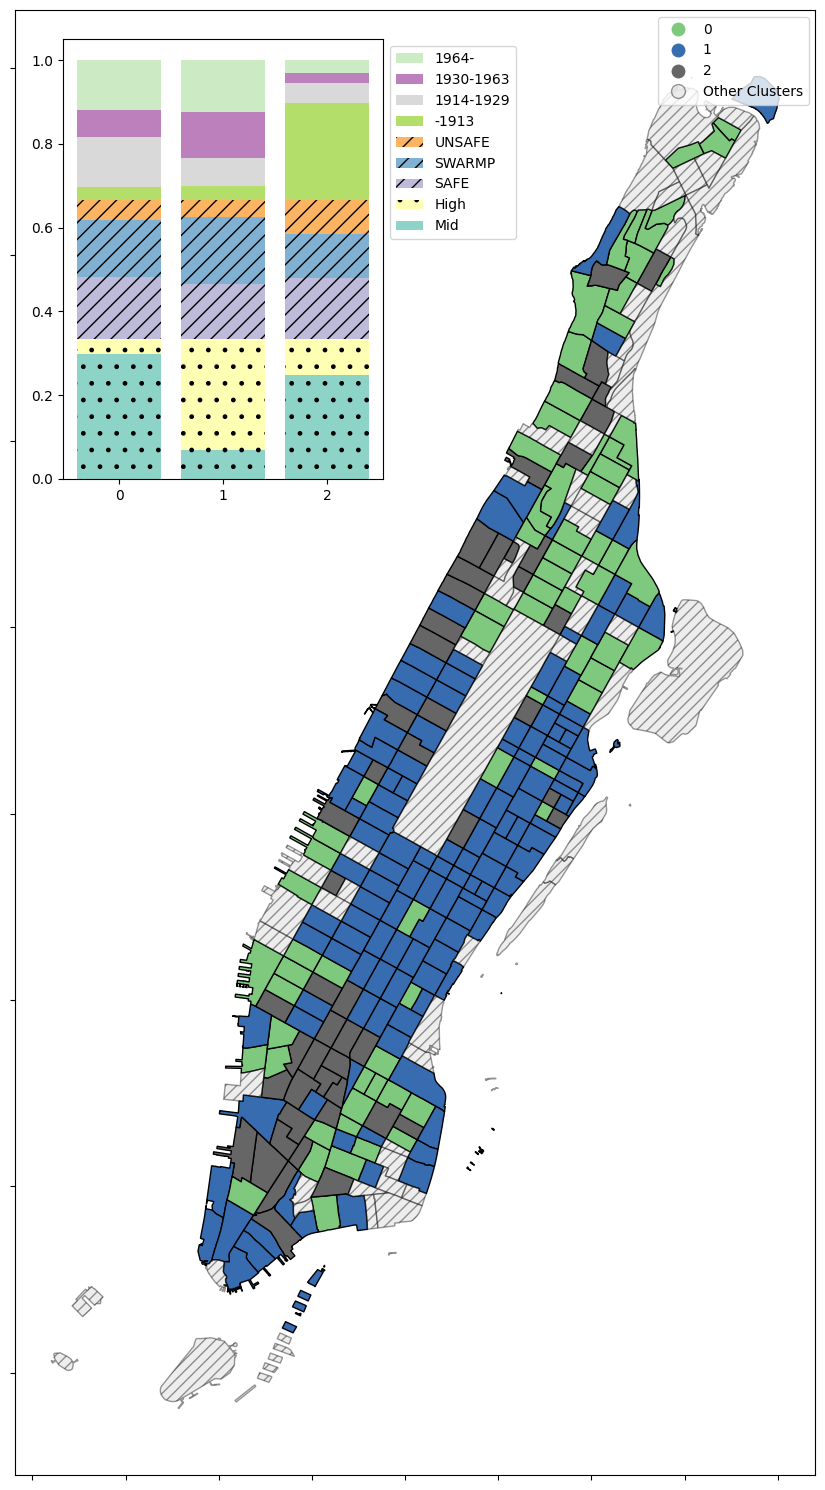

In [ ]:
#### count rodent in each census tract
import urllib.request as urllib
import zipfile

#https://www.nyc.gov/site/planning/data-maps/open-data/census-download-metadata.page

urllib.urlretrieve ("https://s-media.nyc.gov/agencies/dcp/assets/files/zip/data-tools/bytes/nyct2020_23a.zip",
                            "ZIPS.zip")
with zipfile.ZipFile('ZIPS.zip', 'r') as zip_ref:
    zip_ref.extractall('ZIPS/')

nyct2020 = gpd.read_file("ZIPS/nyct2020_23a/nyct2020.shp")
nyct2020 = nyct2020[['GEOID','BoroCode','geometry']]
nyct2020 = nyct2020.to_crs(epsg=2263)
nyct2020_MA = nyct2020[nyct2020.BoroCode=='1']

nyct2020['GEOID'] = nyct2020['GEOID'].astype(int)
nyct2020_MA['GEOID'] = nyct2020_MA['GEOID'].astype(int)

path = '/content/drive/MyDrive/2023 Spring/Other/2022_Overview Of NYC FISP reports/Clustering/archive/test_hub_0401/testCluster_buildingFeatures_allCT_0401.csv'
Feature1 = pd.read_csv(path,index_col='GEOID')

#exclude facadetype
FacadeType = ['Brick masonry', 'Cast iron', 'Concrete', 'Glass', 'Metal and glass', 'Stone limestone','BIN']
selected_col = list(set(Feature1.columns) - set(FacadeType))
FeatureNorm = Feature1[selected_col]

GEOID_MA = nyct2020[nyct2020.BoroCode == '1'].GEOID.tolist()
Feature_MA = FeatureNorm[FeatureNorm.index.isin(GEOID_MA)]

##clustering with KMeans
cluster_num = 3
rr = KMeans(n_clusters = cluster_num, random_state = 0).fit(Feature_MA)
rr.labels_ = rr.predict(Feature_MA) #get labels
clust={Feature_MA.index[i]:rr.labels_[i] for i in range(len(rr.labels_))}
res=pd.DataFrame({'GEOID':Feature_MA.index, 'label':rr.labels_})
# res.to_csv('Gaussian_YearQuantile_4Clust.csv',index=False)

clusterChar = Feature_MA.reset_index().merge(res,left_on='GEOID',right_on='GEOID').\
                    groupby(['label']).sum().reset_index()

#normalize by total cluster activity
clusterChar = clusterChar[[col for col in clusterChar.columns if col not in ['label','GEOID']]]
clusterChar = clusterChar.div(clusterChar.sum(axis=1), axis=0)
clusterChar['label'] = [i for i in range(cluster_num)]

res['label'] = res['label'].astype(str)

fig,ax = plt.subplots(nrows=1, ncols=1,figsize=(15,15))
plt.rcParams["figure.autolayout"] = True
nyct2020_MA.merge(res,left_on='GEOID',right_on='GEOID',how='left').plot(column='label',  cmap='Accent',
                                    legend=True,ax=ax,edgecolor='black', missing_kwds={
                                                            "color": "lightgrey", ## what to do with missing values
                                                            "edgecolor": "black",
                                                            "linewidth": 1,
                                                            "alpha": 0.4,
                                                            "hatch": "///",
                                                            "label": "Other Clusters",
                                                            },)

ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)

ins = ax.inset_axes([0.06,0.68,0.4,0.3])
NUM_COLORS = len(clusterChar.columns)
#camp reference: https://matplotlib.org/stable/gallery/color/colormap_reference.html
cm = plt.cm.get_cmap('Set3', NUM_COLORS)

ins.set_prop_cycle(color = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
bot = np.zeros(cluster_num)

col_order = ['Mid', 'High', 'SAFE', 'SWARMP', 'UNSAFE', '-1913', '1914-1929', '1930-1963', '1964-']

for col in col_order:
    values = clusterChar[col].values
    if col in ['SWARMP','SAFE','UNSAFE']:  #filing status uses hatching pattern,
        ins.bar([i for i in range(cluster_num)], values, bottom = bot, label=col, hatch='//')
    elif col in ['Mid', 'High']: #building height uses dot pattern:
        ins.bar([i for i in range(cluster_num)], values, bottom = bot, label=col, hatch='.')
    else:  #year info uses color block,
        ins.bar([i for i in range(cluster_num)], values, bottom = bot, label=col)
    bot = bot + values

ins.set_xticks([i for i in range(cluster_num)])
handles, labels = ins.get_legend_handles_labels()
order = [i for i in range(len(col_order)-1,0-1,-1)]
ins.legend(bbox_to_anchor=(1.0, 1.0), handles=[handles[idx] for idx in order], labels=[labels[idx] for idx in order])

plt.show()

## NO NEED TO RUN

In [ ]:
def ClusteringPlot(method, eps, cluster_num, dataNormalized, zipcode, ziplabel=True):
    if method=='DBSCAN':
        rr = DBSCAN(eps=eps, min_samples=4).fit(dataNormalized)
    if method=='Gaussian':
        rr = GaussianMixture(n_components = cluster_num, random_state = 0).fit(dataNormalized)
        rr.labels_ = rr.predict(dataNormalized) #get labels
    if method=='KMeans':
        rr=KMeans(random_state=1,n_clusters=cluster_num).fit(dataNormalized) #look for two clusters;
        rr.labels_ = rr.predict(dataNormalized) #get labels

    #create a dictionary mapping zip codes to cluster labels
    clust={dataNormalized.index[i]:rr.labels_[i] for i in range(len(rr.labels_))}

    print([k for k, v in clust.items() if v == 0])

    #create a dataframe
    res=pd.DataFrame({'zipcode':dataNormalized.index, 'label':rr.labels_})

    #characterize each cluster by its aggregated complaint profile
    clusterChar = dataNormalized.reset_index().merge(res,left_on='ZIPCODE',right_on='zipcode').\
                    groupby(['label']).sum().reset_index()

    #normalize by total cluster activity
    clusterChar = clusterChar[[col for col in clusterChar.columns if col not in ['label','ZIPCODE','zipcode']]]
    clusterChar = clusterChar.div(clusterChar.sum(axis=1), axis=0)
    clusterChar['label'] = [i for i in range(cluster_num)]


    #visualize the clustering together with each cluster
    res['label'] = res['label'].astype(str)
    fig,ax = plt.subplots(nrows=1, ncols=1,figsize=(15,15))
    zips.merge(res,left_on='ZIPCODE',right_on='zipcode').plot(column='label',  #cmap='cool',
                                        legend=True,ax=ax,edgecolor='black')
#     ax.tick_params(
#         axis='both',          # changes apply to the x-axis
#         which='both',      # both major and minor ticks are affected
#         bottom=False,      # ticks along the bottom edge are off
#         left=False,         # ticks along the top edge are off
#         labelbottom=False,
#         labelleft=False) # labels along the bottom edge are off

    ins = ax.inset_axes([0.06,0.68,0.4,0.3])
    NUM_COLORS = len(clusterChar.columns)
    cm = plt.cm.get_cmap('tab20', NUM_COLORS)

    ins.set_prop_cycle(color = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
    bot = np.zeros(cluster_num)


    for col in clusterChar.columns:
        if col!= 'label' and col!='ZIPCODE' and col!='zipcode':
            values = clusterChar[col].values
            ins.bar([i for i in range(cluster_num)], values, bottom = bot, label=col)
            bot = bot + values
    ins.set_xticks([i for i in range(cluster_num)])
    ins.legend(bbox_to_anchor=(-0.25, 1))

    ###plot number of building in each zipcode area
    if ziplabel:
        zips1 = zips.merge(Feature1[['BIN']], on='ZIPCODE')

        zips1['coords'] = zips1['geometry'].apply(lambda x: x.representative_point().coords[:])
        zips1['coords'] = [coords[0] for coords in zips1['coords']]
        for idx, row in zips1.iterrows():
            plt.annotate(text=row['BIN'], xy=row['coords'], horizontalalignment='center', color='black')

    return clust

In [ ]:
# score for evaluation
range_n_clusters = [2, 3, 4, 5, 6, 7]
for n_clusters in range_n_clusters: #try different numbers of clusters
    if len(clustDefe) > n_clusters:
        rr = GaussianMixture(n_components = n_clusters, random_state = 0).fit(clustDefe)
        rr.labels_ = rr.predict(clustDefe)
        #report average Silhouette score
        silhouette_avg = silhouette_score(clustDefe, rr.labels_)
        print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.5911717408765035
For n_clusters =3, the average silhouette_score is :0.6164646678703586
For n_clusters =4, the average silhouette_score is :0.502484507784111
For n_clusters =5, the average silhouette_score is :0.4985940196576513
For n_clusters =6, the average silhouette_score is :0.28057309439283745
For n_clusters =7, the average silhouette_score is :0.30833498836740636


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[10103]


<ipython-input-25-0399228f1954>:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('tab20', NUM_COLORS)


{10001: 1,
 10002: 1,
 10003: 1,
 10004: 1,
 10005: 1,
 10006: 1,
 10007: 1,
 10009: 1,
 10010: 1,
 10011: 1,
 10012: 1,
 10013: 1,
 10014: 1,
 10016: 1,
 10017: 1,
 10018: 1,
 10019: 1,
 10021: 1,
 10022: 1,
 10023: 1,
 10024: 1,
 10025: 1,
 10026: 1,
 10027: 1,
 10028: 1,
 10029: 1,
 10030: 1,
 10031: 1,
 10032: 1,
 10033: 1,
 10034: 1,
 10035: 1,
 10036: 1,
 10037: 1,
 10038: 1,
 10039: 1,
 10040: 1,
 10055: 1,
 10065: 1,
 10069: 1,
 10075: 1,
 10081: 1,
 10103: 0,
 10104: 2,
 10106: 2,
 10128: 1,
 10153: 1,
 10154: 1,
 10170: 1,
 10270: 1,
 10280: 1,
 10282: 1}

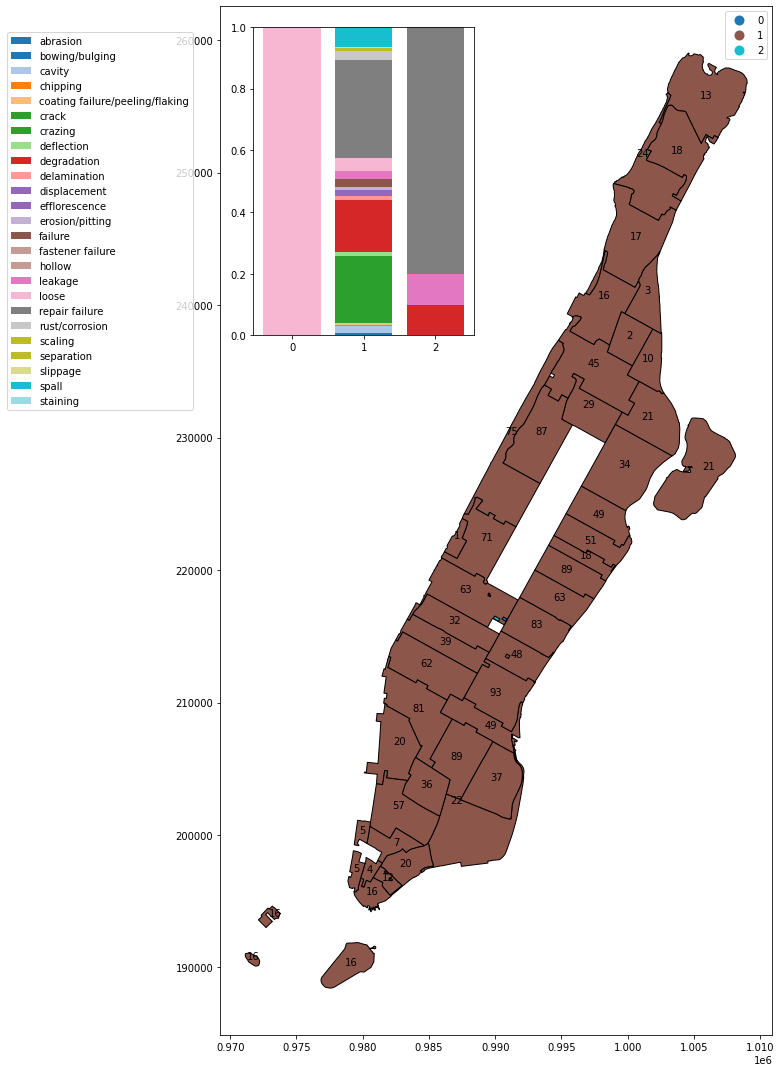

In [ ]:
ClusteringPlot('KMeans',0.1, 3, clustDefe, zips)

In [ ]:
ClusteringPlot('KMeans',0.1, 3, FeatureNorm, zips)

In [ ]:
ClusteringPlot('Gaussian',0.1, 4, FeatureNorm, zips)

In [ ]:
ClusteringPlot('KMeans',0.1, 3, FeatureNorm, zips)

In [ ]:
#elem only
for i in [0.1,0.2,0.3,0.4]:
    ClusteringPlot('DBSCAN',i,2, elementNormalized, zips)

In [ ]:
#facade only
ClusteringPlot('Gaussian',2, facadeNormalized2, zips)